# Deep Learning at Neuromatch 2021
Tanvi Ranjan, August 2021
## Week 2, Day 3: Modern RNNs
[W2D3, Modern Recurrent Neural Networks](https://deeplearning.neuromatch.io/tutorials/W2D3_ModernRecurrentNeuralNetworks/student/W2D3_Tutorial2.html)

The previous tutorial is ground up and very useful for building fundamental understanding. I'm skipping it for now in the interest of time, but intend to come back to it soon

In this tutorial, I will use LSTMs and GRUs for classification

In [2]:
pip install d2l --quiet

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Imports
import math
import time
import nltk
import random
import collections

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchtext import data, datasets

from d2l import torch as d2l

import random
import torch

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [7]:
def load_dataset(sentence_length=50, batch_size=32, seed=522):

    TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  # If no specific vector embeddings are specified,
  # Torchtext initializes random vector embeddings
  # which would get updated during training through backpropagation.
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

    return TEXT, vocab_size, train_iter, valid_iter, test_iter
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:15<00:00, 5.36MB/s]


Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


In [39]:
def train(model, train_iter, valid_iter, epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss=[]; train_acc=[]; valid_loss=[]; valid_acc=[];
    for epoch in tqdm(range(epochs),position=0,leave=True):
        model.train();
        running_loss=0.0;
        correct, total = 0,0
        for batch in train_iter:
            text, label = batch.text[0], torch.autograd.Variable(batch.label).long();
            #conversion to long for label is required, but not sure why
            optimizer.zero_grad();
            output = model(text);
            loss = loss_fn(output, label);
            loss.backward();
            optimizer.step();
            
            running_loss+=loss.item()
            
            _,predicted = torch.max(output, 1);
            total += label.size(0);
#             pdb.set_trace();
            correct += (predicted==label).sum().item();
        train_loss.append(running_loss/len(train_iter));
        train_acc.append(correct/total)
        
        model.eval();
        running_loss=0.0; correct,total=0,0;
        with torch.no_grad():
            for batch in valid_iter:
                text,label=batch.text[0], torch.autograd.Variable(batch.label).long();
                output = model(text);
                loss = loss_fn(output,label);
                running_loss +=loss.item();
                total+=label.size(0);
                
                _,predicted = torch.max(output,1);
                correct +=(predicted==label).sum().item();
        valid_loss.append(running_loss/len(valid_iter));
        valid_acc.append(correct/total)
    return train_loss, valid_loss, train_acc, valid_acc
        

In [36]:
# Training function
def train_from_tutorial(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in tqdm(range(epochs),position=0,leave=True):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      # print(type(text), text.shape)
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, '
          f'Training Loss: {running_loss/len(train_iter):.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc



In [40]:
class VanillaRNN(nn.Module):
    def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
        super(VanillaRNN,self).__init__();
        self.n_layers = layers
        self.hidden_size=hidden_size
        self.device = device;
        self.embeddings = nn.Embedding(vocab_size,embed_size);
        self.rnn = nn.RNN(embed_size,hidden_size,self.n_layers)
        self.fc = nn.Linear(self.n_layers*hidden_size,output_size);
    def forward(self,x):
        x=self.embeddings(x);
        x=x.permute(1,0,2);
        h0=torch.zeros(2,x.size()[1],self.hidden_size);
        output, hn=self.rnn(x,h0);
        hn=hn.permute(1,0,2);
        hn=hn.contiguous().reshape(hn.size()[0], hn.size()[1]*hn.size()[2])
        logits = self.fc(hn);
        return logits
vanillaRNN = VanillaRNN(2,2,50,vocab_size,100,'cpu');
train_loss, train_acc, valid_loss, valid_acc = train(vanillaRNN, 
                                                         train_iter, 
                                                         valid_iter, 
                                                         10, 2e-4)

100%|██████████| 10/10 [17:57<00:00, 99.13s/it]


In [37]:
train_tut_loss, train_tut_acc, valid_tut_loss, valid_tut_acc = train_from_tutorial(vanillaRNN,
                                                                                   'cpu',
                                                         train_iter, 
                                                         valid_iter, 
                                                         10, 2e-4)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.4682, Training Accuracy:  78.82%


 10%|█         | 1/10 [01:52<16:54, 112.76s/it]

Validation Loss: 0.6508, Validation Accuracy:  68.08%
Epoch: 2, Training Loss: 0.4503, Training Accuracy:  79.99%


 20%|██        | 2/10 [03:15<13:50, 103.76s/it]

Validation Loss: 0.6548, Validation Accuracy:  67.27%
Epoch: 3, Training Loss: 0.4170, Training Accuracy:  81.85%


 30%|███       | 3/10 [04:33<11:12, 96.01s/it] 

Validation Loss: 0.6589, Validation Accuracy:  68.73%
Epoch: 4, Training Loss: 0.3886, Training Accuracy:  83.46%


 40%|████      | 4/10 [05:51<09:03, 90.62s/it]

Validation Loss: 0.6592, Validation Accuracy:  68.60%
Epoch: 5, Training Loss: 0.3612, Training Accuracy:  85.02%


 50%|█████     | 5/10 [07:13<07:19, 87.97s/it]

Validation Loss: 0.6742, Validation Accuracy:  69.35%
Epoch: 6, Training Loss: 0.3309, Training Accuracy:  86.63%


 60%|██████    | 6/10 [08:31<05:40, 85.10s/it]

Validation Loss: 0.7201, Validation Accuracy:  68.68%
Epoch: 7, Training Loss: 0.3064, Training Accuracy:  88.11%


 70%|███████   | 7/10 [09:49<04:08, 82.80s/it]

Validation Loss: 0.7214, Validation Accuracy:  69.52%
Epoch: 8, Training Loss: 0.2815, Training Accuracy:  89.11%


 80%|████████  | 8/10 [11:06<02:42, 81.20s/it]

Validation Loss: 0.7406, Validation Accuracy:  68.73%
Epoch: 9, Training Loss: 0.2620, Training Accuracy:  89.98%


 90%|█████████ | 9/10 [12:24<01:20, 80.08s/it]

Validation Loss: 0.7646, Validation Accuracy:  70.24%
Epoch: 10, Training Loss: 0.2277, Training Accuracy:  91.70%


100%|██████████| 10/10 [13:40<00:00, 79.05s/it]

Validation Loss: 0.7965, Validation Accuracy:  69.52%


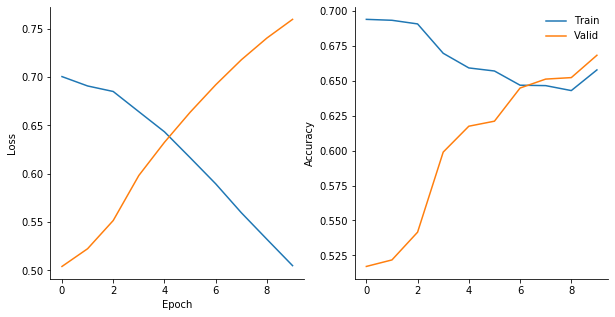

In [34]:
f,ax=plt.subplots(1,2,figsize=(10,5),sharex=True);
ax[0].plot(train_loss,label='Train'); ax[0].plot(valid_loss,label='Valid');
ax[0].set_ylabel('Loss'); ax[0].set_xlabel('Epoch')

ax[1].plot(train_acc,label='Train'); ax[1].plot(valid_acc,label='Valid');
ax[1].set_ylabel('Accuracy')

ax[1].legend(frameon=False); sns.despine()

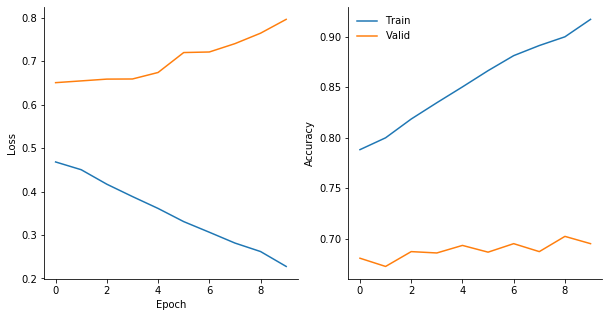

In [38]:
f,ax=plt.subplots(1,2,figsize=(10,5),sharex=True);
ax[0].plot(train_tut_loss,label='Train'); ax[0].plot(valid_tut_loss,label='Valid');
ax[0].set_ylabel('Loss'); ax[0].set_xlabel('Epoch')

ax[1].plot(train_tut_acc,label='Train'); ax[1].plot(valid_tut_acc,label='Valid');
ax[1].set_ylabel('Accuracy')

ax[1].legend(frameon=False); sns.despine()